
--- Clustered MVP ---

Portfolio Weights:
Clustered MVP: [2.59426366e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.17529492e-17 0.00000000e+00 0.00000000e+00
 1.54691615e-17 8.64379429e-18 3.95906331e-18 0.00000000e+00
 0.00000000e+00 1.12755622e-17 2.17954985e-17 9.53364311e-18
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.59268862e-18
 0.00000000e+00 1.12200153e-17 2.64748393e-17 8.34880880e-18
 8.92144832e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.60381107e-18 0.00000000e+00 1.13562345e-17 0.00000000e+00
 5.15227833e-18 2.40961903e-03 7.58647038e-03 1.71001845e-02
 1.89815533e-02 2.23815896e-02 3.36760993e-02 4.24620583e-02
 1.00127966e-01 1.32802971e-01 1.35056542e-01 1.59124878e-01
 1.63544854e-01 1.64745215e-01]
Control: [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0

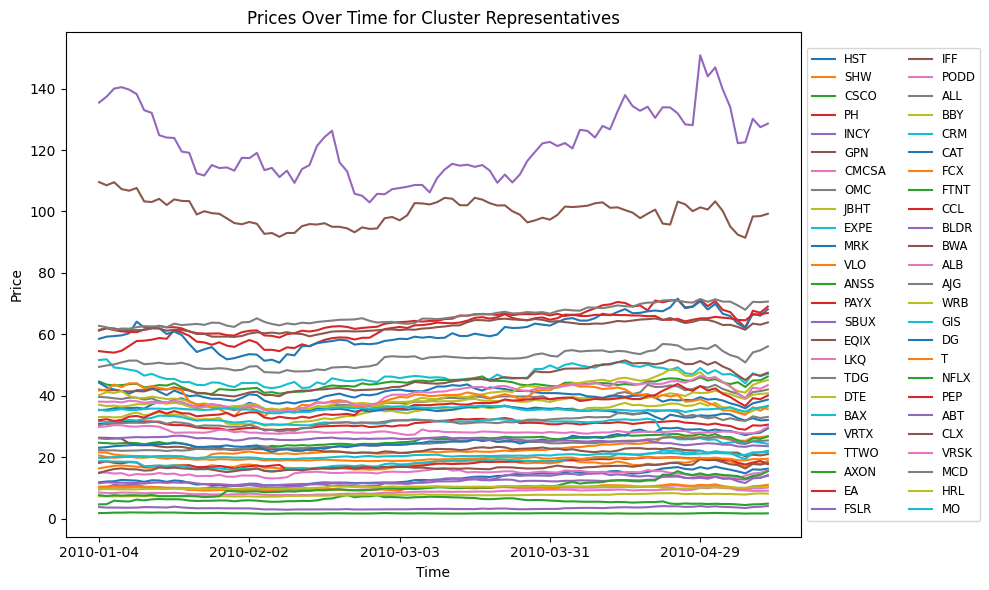

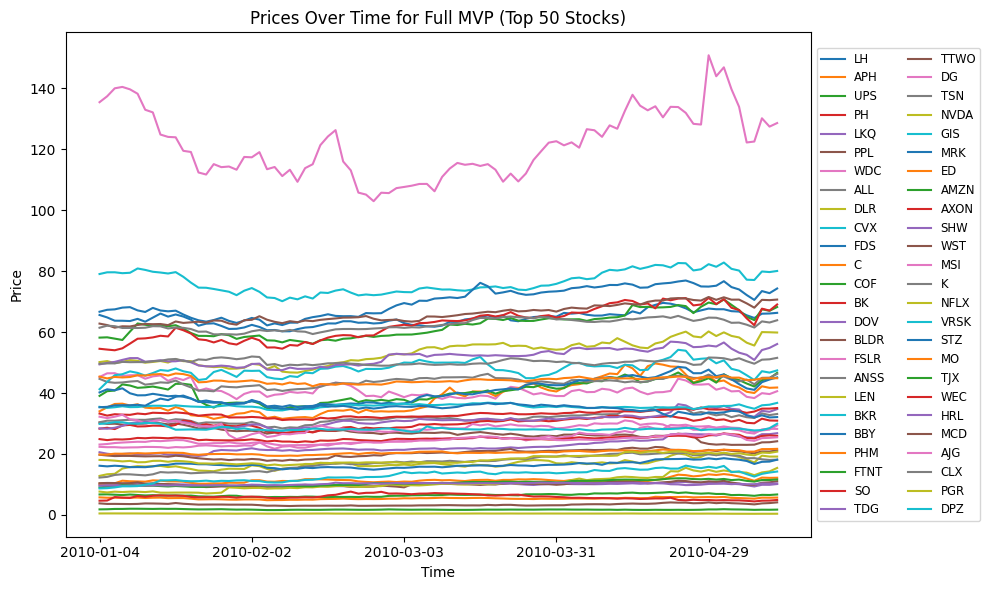

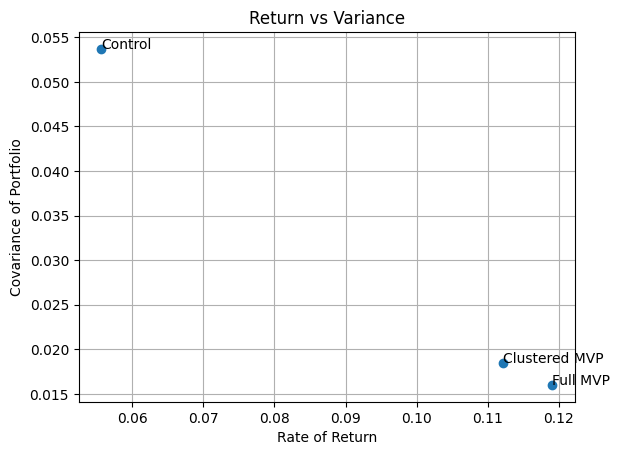

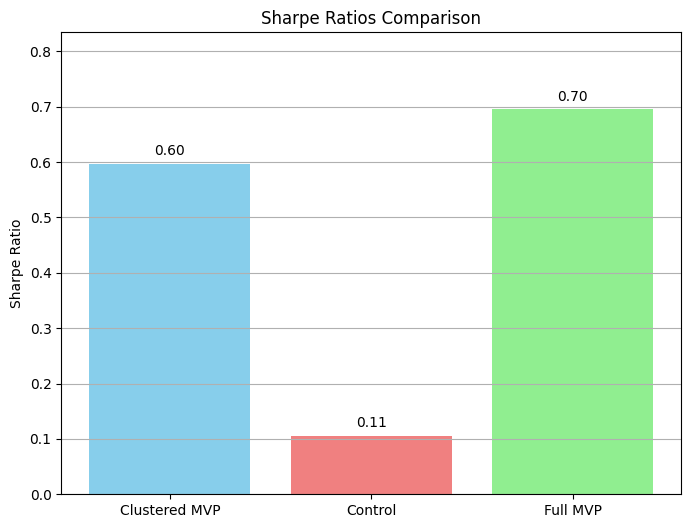

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
from scipy.optimize import minimize
import math
import warnings

stocks_df = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_stocks.csv')
tickers = stocks_df['Symbol'].unique()

#process prices into pivot table 
price_df = stocks_df.pivot(index='Date', columns='Symbol', values='Close')
price_df = price_df.dropna(axis=1)  # remove stocks with missing prices
tickers = price_df.columns.tolist()

#compute Daily Returns
returns_df = price_df.pct_change().dropna()

def compute_distance_matrix(returns):
    """
    computes a distance matrix based on correlation between asset returns

    Parameters:
    - returns (DataFrame): Return data.

    Returns:
    - (ndarray): Distance matrix where distance = 1 - correlation.
    """
    corr = returns.corr().to_numpy()
    dist = 1 - corr
    return dist

def agglomerative_clustering(distance_matrix, num_clusters):
    """
    performs basic agglomerative hierarchical clustering using average linkage

    Parameters:
    - distance_matrix (ndarray): Distance between stocks
    - num_clusters (int): Desired number of clusters

    Returns:
    - (list of lists): Each inner list contains indices of stocks in one cluster
    """
    n = distance_matrix.shape[0]
    clusters = [[i] for i in range(n)]
    while len(clusters) > num_clusters:
        min_dist = float('inf')
        to_merge = (0, 1)
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                dist_ij = np.mean([
                    distance_matrix[a][b]
                    for a in clusters[i]
                    for b in clusters[j]
                ])
                if dist_ij < min_dist:
                    min_dist = dist_ij
                    to_merge = (i, j)
        i, j = to_merge
        merged = clusters[i] + clusters[j]
        clusters = [c for k, c in enumerate(clusters) if k not in (i, j)]
        clusters.append(merged)
    return clusters

def select_representatives(clusters, returns_df, symbols):
    """
    selects one representative stock from each cluster: the one most similar to others in cluster with 
    smallest average distance to all other stocks in cluster

    Parameters:
    - clusters (list of lists): Output from agglomerative_clustering.
    - returns_df (DataFrame): Daily returns data.
    - symbols (list): List of all stock symbols.

    Returns:
    - (list): Symbols representing each cluster.
    """
    corr_matrix = returns_df.corr()
    representatives = []
    for cluster in clusters:
        if len(cluster) == 1:
            representatives.append(symbols[cluster[0]])
            continue
        min_avg_dist = float('inf')
        rep = cluster[0]
        for i in cluster:
            distances = [1 - corr_matrix.iloc[i, j] for j in cluster if i != j]
            if not distances:
                continue
            avg_dist = np.mean(distances)
            if avg_dist < min_avg_dist:
                min_avg_dist = avg_dist
                rep = i
        representatives.append(symbols[rep])

    return representatives

#MVP functions
def compute_returns(prices, time):
    """
    computes log returns and expected returns over a specified time horizon.

    Parameters:
    - prices (DataFrame): Stock prices with dates as rows and symbols as columns.
    - time (int): Number of trading days to scale the expected returns.

    Returns:
    - returns (DataFrame): Daily log returns for each stock.
    - e_returns (Series): Expected returns scaled over the input time 
    """
    returns = np.log(prices / prices.shift(1)).dropna()
    
    daily_mean_returns = returns.mean()
    e_returns = daily_mean_returns * time
    
    return returns, e_returns

def build_estimate_covariance_matrix(returns, time):
    """
    builds the estimated covariance matrix of asset returns, scaled over time

    Parameters:
    - returns (DataFrame): Daily returns for each asset.
    - time (int): Scaling factor (number of trading days)

    Returns:
    - (ndarray): Covariance matrix (scaled by time)
    """
    return returns.cov().to_numpy()*time

def global_min_var_portfolio(mu, cov_matrix, mu_target):
    """
    solves for the weights of a global minimum variance portfolio given a return target

    Parameters:
    - mu (ndarray): Expected returns vector for each asset.
    - cov_matrix (ndarray): Covariance matrix of asset returns.
    - mu_target (float): Target expected return for the portfolio.

    Returns:
    - (ndarray): Optimal weights for the portfolio.
    """
    n = len(mu)
    mu = mu.reshape((n,))
    ones = np.ones(n)

    def objective(x):
        return np.dot(x.T, np.dot(cov_matrix, x))

    constraints = [
        {'type': 'eq', 'fun': lambda x: np.dot(mu, x) - mu_target},  # target return
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}               # sum to 1
    ]

    # no shorting constraint
    bounds = [(0, 1) for _ in range(n)]

    # initial guess is control
    x0 = ones / n

    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed: " + result.message)

def run_experiment(prices, start_train, end_train, start_test, end_test):
    """
    runs an MVP optimization experiment with a training and testing phase.

    Parameters:
    - prices (DataFrame): Price data for the assets.
    - start_train, end_train (int): Training date indices.
    - start_test, end_test (int): Testing date indices.

    Returns:
    - (dict): Portfolio performance metrics including weights, return, variance, and Sharpe ratio.
    """
    num_stocks = prices.shape[1]
    n = end_train - start_train
    m = end_test - start_test

    # increase to penalize risk more
    risk_free_rate = np.log(1.04) * (m/252)  # r = log(1 + annual_rate)*(time/252)
    
    # returns and expected returns
    ret, mu = compute_returns(prices.iloc[start_train:end_train], n)
    ret_test, mu_test = compute_returns(prices.iloc[start_test:end_test], m)
    
    # estimate covariance matrix
    estimate_covariance = build_estimate_covariance_matrix(ret, n)
    covariance_test = build_estimate_covariance_matrix(ret_test, m)
    
    # portfolios
    MVP = global_min_var_portfolio(mu.to_numpy(), estimate_covariance, 0.25)
    Control = np.ones(num_stocks) / num_stocks
    
    MVP_return = np.dot(mu_test, MVP)
    Control_return = np.dot(Control, mu_test)
    
    MVP_cov = np.dot(np.dot(MVP.T, covariance_test), MVP)
    Control_cov = np.dot(np.dot(Control.T, covariance_test), Control)
    

    MVP_sharpe = (MVP_return - risk_free_rate) / math.sqrt(MVP_cov)
    Control_sharpe = (Control_return - risk_free_rate) / math.sqrt(Control_cov)

    metrics = {'MVP Weights': MVP,
               'Control Weights': Control,
               'MVP Return' : MVP_return, 
               'Control Return': Control_return,
               'MVP Cov' : MVP_cov,
               'Control Cov': Control_cov,
               'MVP Sharpe': MVP_sharpe,
               'Control Sharpe': Control_sharpe}
    return metrics

#select representative prices of clustered stocks and run experiment
# main process: 100 clusters -> MVP -> select top 50 by weight -> rerun MVP
distance_matrix = compute_distance_matrix(returns_df)
clusters_100 = agglomerative_clustering(distance_matrix, num_clusters=100)
reps_100 = select_representatives(clusters_100, returns_df, tickers)
rep_prices_100 = price_df[reps_100].copy()

intermediate_results = run_experiment(rep_prices_100, 0, 400, 400, 600)
cluster_top_50_indices = np.argsort(intermediate_results['MVP Weights'])[-50:]
cluster_top_50_tickers = [reps_100[i] for i in cluster_top_50_indices]
cluster_top_50_prices = price_df[cluster_top_50_tickers]

results = run_experiment(cluster_top_50_prices, 0, 400, 400, 600)

results

# compute returns and covariance for all 500 stocks for full MVP
full_returns, full_mu = compute_returns(price_df, time=400)
full_covariance = build_estimate_covariance_matrix(full_returns, time=400)

# run MVP optimization on all 500 stocks using target return
full_MVP_weights = global_min_var_portfolio(full_mu.to_numpy(), full_covariance, mu_target=0.25)

# select top 50 stocks based on absolute MVP weights for full MVP
top_50_indices = np.argsort(full_MVP_weights)[-50:]
top_50_tickers = price_df.columns[top_50_indices]
top_50_prices = price_df[top_50_tickers]

results_full_MVP = run_experiment(top_50_prices, 0, 400, 400, 600)

warnings.filterwarnings("ignore", category=RuntimeWarning) #to prevent log(0) warnings

# results output
print("\n--- Clustered MVP ---")
print("\nPortfolio Weights:")
print("Clustered MVP:", results['MVP Weights'])
print("Control:", results['Control Weights'])

print("\nReturns:")
print("Clustered MVP Return:", results['MVP Return'])
print("Control Return:", results['Control Return'])

print("\nVariances:")
print("Clustered MVP Variance:", results['MVP Cov'])
print("Control Variance:", results['Control Cov'])

print("\nSharpe Ratios:")
print("Clustered MVP Sharpe:", results['MVP Sharpe'])
print("Control Sharpe:", results['Control Sharpe'])

print("\n--- Full MVP ---")
print("MVP Weights:", results_full_MVP['MVP Weights'])
print("Control Weights:", results_full_MVP['Control Weights'])
print("MVP Sharpe:", results_full_MVP['MVP Sharpe'])
print("Control Sharpe:", results_full_MVP['Control Sharpe'])

# plot results
cluster_top_50_prices.iloc[:90].plot(figsize=(10, 6))
plt.title("Prices Over Time for Cluster Representatives")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# prices for full MVP
top_50_prices.iloc[:90].plot(figsize=(10, 6))
plt.title("Prices Over Time for Full MVP (Top 50 Stocks)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# Return vs Variance Scatter
x = [results['MVP Return'], results['Control Return'], results_full_MVP['MVP Return']]
y = [results['MVP Cov'], results['Control Cov'], results_full_MVP['MVP Cov']]
labels = ["Clustered MVP", "Control", "Full MVP"]

fig, ax = plt.subplots()
ax.scatter(x, y)
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.xlabel("Rate of Return")
plt.ylabel("Covariance of Portfolio")
plt.title("Return vs Variance")
plt.grid(True)
plt.show()

# plot sharpe ratios
sharpe_ratios = [
    results['MVP Sharpe'],
    results['Control Sharpe'],
    results_full_MVP['MVP Sharpe']
]

labels = ['Clustered MVP', 'Control', 'Full MVP']
colors = ['skyblue', 'lightcoral', 'lightgreen']

plt.figure(figsize=(8, 6))
plt.bar(labels, sharpe_ratios, color=colors)
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios Comparison')
for i, v in enumerate(sharpe_ratios):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
plt.ylim(0, max(sharpe_ratios)*1.2)
plt.grid(axis='y')
plt.show()